# DATA 620 - Project 1 (Week 5)

## Introduction

In this project, we explore the daily log-return correlation network of the current single stock constituents of the  S&P500 equity index. We use sector and sub-industry categorical data for each of the stocks comprising the current S&P500 to determine whether these variables influence co-movement in the returns of groups of stocks. In the first section, data required to perform the study is  acquired through a combination of web-scraping and the use of an API. In the second section, we build and explore the unfiltered correlation network, computing both weighted degree and eigenvector centrality, then examining the relationship between these metrics and the categorical variable (sub-industry). In the third section, we filter the network using Prim's algorithm to produce a minimum spanning tree (MST) representation of the graph, then re-examine weighted degree. In the last section, we present conclusions and outline potential practical applications.


## Data Acquisition & Cleaning

To perform the analysis briefly outlined above, we require a list of the current constituents of the S&P500 index, along with corresponding sector, sub-industry, and price data. 

We start by acquiring the required data. The first part of the data set - the instrument master for our universe under study - is scraped from Wikipedia (https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). The second part of our data set - corresponding prices for each instrument - are collected from Yahoo finance using the 'pandas_datareader' package.

In [234]:
# import the required packages

# analytics
import pandas
import pandas_datareader
import numpy
import math
# date and time
import datetime
import time
from timeit import default_timer as timer
# graphics
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
# networks
import networkx
# web
import urllib2
from bs4 import BeautifulSoup
# OS
import os

# inline matplotlib
%matplotlib inline

In [235]:
# function to create a directory if it does not exist
def ensure_directory(f):
    d = os.path.dirname(f)
    if not os.path.exists(d):
        os.makedirs(d)
        
# function to fetch current single stock components of S&P500 equity index for wikipedia
def fetchSP500_components_wiki(outputDirectory,endDate):

    outputFileName="sp-500_constituents_"+endDate.strftime('%Y%m%d_%H%M%S')
    #
    outputFileHandle = open( outputDirectory + outputFileName,'w')

    url="http://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

    # fetch the url
    req = urllib2.Request(url, headers={'User-Agent' : "Magic Browser"}) 
    response = urllib2.urlopen( req ) 
    s = response.read()
    response.close()
    # 
    soup = BeautifulSoup(s, "lxml")
        
    # fetch the table
    table = soup.find("table", attrs={"class":"wikitable sortable"})    
    # fetch the returns
    records = table.find_all(["tr"])

    # iterate over the table line for each component
    for record in records:
        # parse the line    
        line=record.text.split('\n')
        instrumentTicker=str(line[1])
        instrumentName=str(line[2])
        sector=str(line[4])
        subIndustry=str(line[5])

        # write line to the output file
        try:
            #print(instrumentTicker+"|"+instrumentName+"|"+sector+"|"+subIndustry+"|"+dateFirstAdded+"|"+CIK)
            outputFileHandle.write(instrumentTicker+"|"+instrumentName+"|"+sector+"|"+subIndustry+"\n")
        except:
            print('cannot write')

    # close the output file
    outputFileHandle.close()

    return outputFileName

# function to fetch yahoo data for ticker between start and end dates (no corporate actions)
def fetchYahooData(yahooTicker,instrumentName,gicsSectorName,gicsSubIndustryName,
    startDate, endDate):
    # fetch historical data
    df = pandas_datareader.data.DataReader(yahooTicker, 'yahoo', startDate, 
        endDate)

    # iterate backwards over the prices and compute the adj factor
    df1=df.copy(deep=True)

    #dateTime=df1.index
    openPrice=numpy.array(df1['Open'].values, dtype='d')
    highPrice=numpy.array(df1['High'].values, dtype='d')
    lowPrice=numpy.array(df1['Low'].values, dtype='d')
    closePrice=numpy.array(df1['Close'].values, dtype='d')
    adjustedClosePrice=numpy.array(df1['Adj Close'].values, dtype='d')
        
    T=len(df)
    adjustCount=0
    for t in xrange(T-1,-1,-1):
       
        if closePrice[t] != adjustedClosePrice[t]:
            factor = adjustedClosePrice[t]/closePrice[t]
            adjustCount=adjustCount+1
            
            for tt in xrange(t,-1,-1):
                openPrice[tt]=openPrice[tt]*factor
                highPrice[tt]=highPrice[tt]*factor
                lowPrice[tt]=lowPrice[tt]*factor
                closePrice[tt]=closePrice[tt]*factor                

    df['adjOpen']=numpy.array(openPrice, dtype='d')
    df['adjHigh']=numpy.array(highPrice, dtype='d')
    df['adjLow']=numpy.array(lowPrice, dtype='d')
    df['adjClose']=numpy.array(closePrice, dtype='d')
                            
    # add true range and 20d ATR
    previousClosePrice=df['adjClose'].shift(1)
    a=df['adjHigh']-df['adjLow']
    b=abs(df['adjHigh']-previousClosePrice)
    c=abs(previousClosePrice-df['adjLow'])
    test=pandas.concat([a,b,c],axis=1)
    # compute true range
    trueRange=test.max(axis=1,skipna=False)
    trueRange.reindex(df.index,method='ffill')
    df['trueRange']=trueRange
    # compute the 20d atr
    atrLookback=20
    
    atr=trueRange.ewm(span=atrLookback,min_periods=atrLookback,adjust=True,
        ignore_na=True).mean()
    
    df['atr_20d']=numpy.array(numpy.around(atr, decimals=2, out=None), 
      dtype='d')
    
    # add instrument info              
    df['yahooTicker']=str(yahooTicker)
    df['instrumentName']=str(instrumentName)
    df['gicsSectorName']=str(gicsSectorName)
    df['gicsSubIndustryName']=str(gicsSubIndustryName)

    return df

In [236]:
# If the data acquisition flag is set to 'true', we scrape Wikipedia 
# for the current list of S&P500 constituents and fetch price data 
# from Yahoo finance for each component in the list. All data is stored 
# in a HDF5 file for use below. If the flag is set to 'false' we skip the 
#data acquisition and read the HDF5 file created by a previous data 
# acquisition run.

# code to acquire data
fetchDataFlag=False

# set error directory
errorDirectory="D:/marketData/global_monitoring/yahoo/"
# set output directory
outputDirectory="D:/marketData/global_monitoring/instrument_universe/wiki/sp-500/"
# set base directory
baseDirectory="D:/marketData/global_monitoring/yahoo/sp500_wiki/"

if (fetchDataFlag == True):
    # set start date
    startDate = datetime.datetime(1990, 1, 1)
    # set end date
    endDate = datetime.datetime.now()
    # define price output directory
    priceDirectory=baseDirectory+endDate.strftime('%Y%m%d_%H%M%S')+"/"
    # create price file output directory if does not exist
    ensure_directory(priceDirectory)
    # define error file name
    errorFileName="error_sp500_"+endDate.strftime('%Y%m%d_%H%M%S')
    # open error file handle
    errorHandle = open( errorDirectory + errorFileName,'w')

    # fetch the S&P500 components from wikipedia
    outputFileName=fetchSP500_components_wiki(outputDirectory,endDate)
    # read the instrument master into dataframe
    instrumentMaster=pandas.read_csv(outputDirectory+outputFileName,sep='|')

    # start timer (prices)
    ts_fetchPrices = timer()

    dataDictionary=dict()
    error=dict()

    # iterate over each instrument
    for instrument_index, instrument in instrumentMaster.iterrows():
        # extract instrument details
        instrumentTicker=instrument[0]
        instrumentName=instrument[1]
        gicsSectorName=instrument[2]
        gicsSubIndustryName=instrument[3]
    
        print(instrumentTicker+"|"+instrumentName+"|"+gicsSectorName+"|"+gicsSubIndustryName)

        try:
            #
            priceFileName=instrumentTicker+'_'+endDate.strftime('%Y%m%d_%H%M%S')
            # fetch price from yahoo
            price=fetchYahooData(instrumentTicker,instrumentName,gicsSectorName,
                gicsSubIndustryName,startDate, endDate)
            # write price
            price.to_csv(priceDirectory+priceFileName,sep='|',index=True,
                index_label='asOfDate',float_format='%g',na_rep='\N')
            # log complete
            errorHandle.write("COMPLETE|"+instrumentTicker+"|"+instrumentName+"|"+gicsSectorName+"|"+gicsSubIndustryName+"|"+endDate.strftime('%Y-%m-%d %H:%M:%S')+"\n")
            # sleep for 10 seconds
            time.sleep(10)
            # add price dataframe to data dictionary 
            dataDictionary[instrumentTicker]=price

        except:
            # log error
            errorHandle.write("ERROR|"+instrumentTicker+"|"+instrumentName+"|"+gicsSectorName+"|"+gicsSubIndustryName+"|"+endDate.strftime('%Y-%m-%d %H:%M:%S')+"\n")
            # add instrument name to error dictionary
            error[instrumentTicker]=instrumentName
        
    # close error log
    errorHandle.close()

    # convert the error dictionary to a dataframe
    errorData=pandas.DataFrame.from_dict(error,orient='index')            

    # end timer (prices)
    te_fetchPrices = timer()

    # compute time elasped
    timeElasped_fetchPrices=te_fetchPrices-ts_fetchPrices

    # display time elasped
    print('Time Elasped: '+str(timeElasped_fetchPrices))
   
    # create the data panel
    groupData=pandas.Panel.from_dict(dataDictionary,orient='minor')
    # extract the prices
    prices=groupData['adjClose']
    # extract the true ranges
    trueRanges=groupData['trueRange']

    # set the HDF5 output file directory
    output_directory=baseDirectory
    # create the directory if it does not exist
    ensure_directory(output_directory)      
    output_file='sp500_wiki_yahoo.h5'
    # create the HDF5 data store
    data_store = pandas.HDFStore(output_directory+output_file)
    # store the 'prices' data frame in the HDF5 data store
    data_store['price'] = prices
    # store the 'true ranges' data frame in the HDF5 data store
    data_store['trueRange'] = trueRanges
    # store the 'error tickers' data frame in the HDF5 data store
    data_store['error'] = errorData
    # store instrument master
    data_store['instrumentMaster'] = instrumentMaster
    # close the HDF5 data store
    data_store.close()    
    

## Data Exploration

In this section we briefly explore the acquired data.

In [237]:
# We load an instrument master which maps each equity instrument 
# to instrument characteristics such as instrument name,  sector, 
# and sub-industry:

# set the HDF5 output file directory
instrumentMasterDirectory='C:/Users/Derek/Documents/GitHub/DATA_620/Projects/W5/'
# define the input file name for prices and true range
instrumentMasterFileName='sp500_wiki_yahoo.h5'
# read instrument master from the HDF5 data store
instrumentMaster = pandas.read_hdf(instrumentMasterDirectory+instrumentMasterFileName,
    'instrumentMaster')
# rename columns
instrumentMaster.rename(columns={'Ticker symbol' : 'instrumentTicker',
    'Security' : 'instrumentName','GICS Sector' : 'gicsSectorName',
    'GICS Sub Industry' : 'gicsSubIndustryName'},inplace=True)

Using the instrument master data gathered, we group stocks by sector and sub-industry.

In [238]:
instrumentMaster.groupby(['gicsSectorName'])['gicsSectorName'].count()

gicsSectorName
Consumer Discretionary        83
Consumer Staples              34
Energy                        32
Financials                    68
Health Care                   62
Industrials                   66
Information Technology        70
Materials                     25
Real Estate                   33
Telecommunication Services     4
Utilities                     28
Name: gicsSectorName, dtype: int64

In [239]:
instrumentMaster.groupby(['gicsSectorName','gicsSubIndustryName'])['gicsSubIndustryName'].count()

gicsSectorName              gicsSubIndustryName                         
Consumer Discretionary      Advertising                                      2
                            Apparel Retail                                   5
                            Apparel, Accessories & Luxury Goods             10
                            Auto Parts & Equipment                           2
                            Automobile Manufacturers                         2
                            Automotive Retail                                1
                            Broadcasting                                     1
                            Cable & Satellite                                9
                            Casinos & Gaming                                 2
                            Computer & Electronics Retail                    1
                            Consumer Electronics                             1
                            Department Stores             

In [240]:
# We load the price data from the HDF5 file

# set the HDF5 output file directory
priceDirectory='C:/Users/Derek/Documents/GitHub/DATA_620/Projects/W5/'
# define the input file name for prices and true range
priceFileName='sp500_wiki_yahoo.h5'
# read the price data from the HDF5 data store
prices = pandas.read_hdf(priceDirectory+priceFileName,'price')
# reindex
prices=prices.set_index(pandas.to_datetime(prices.index))
# define subset
startDate='2006-10-31'
# subset
prices=prices.loc[startDate:]

In [241]:
# The number of observations available for each ticker is as follows:

# find the number of observations available for each ticker
numberOfObservations=numpy.sum(prices.isnull()==False,axis=0)
# print the result
#print(numberOfObservations)

The distribution of the number of observations available for each ticker reveals that most of the stocks have 2748 daily periods. In the following work, we focus only on the stocks for which a full sample of 2748 daily periods is available.

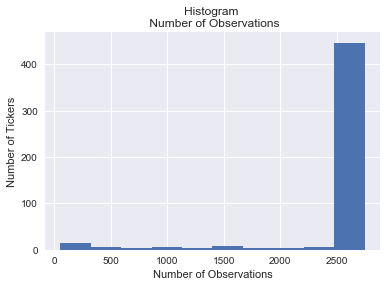

In [242]:
numberOfObservations.hist()
plt.title('Histogram \n Number of Observations')
plt.xlabel('Number of Observations')
plt.ylabel('Number of Tickers')

In [243]:
# find the single stocks with full samples
fullSampleIndex=numberOfObservations==2748
# extract the prices for the single stocks with full samples
cleanPrices=prices.loc[:,fullSampleIndex]
# find the instrument master records with full price samples
fullSampleInstrumentIndex=instrumentMaster['instrumentTicker'].isin(cleanPrices.columns.values)
# extract the instrument master records with full price samples
instrumentMaster=instrumentMaster.loc[fullSampleInstrumentIndex]

For each stock in the S&P500, we compute the daily log-return from the price (i.e., we first- difference the logarithm of the price), then 'standardize' by removing the mean and dividing by the standard deviation.

In [244]:
# We compute the log returns:

# log price by instrument
logPrices=numpy.log(cleanPrices)
# first difference to get returns
logReturns=logPrices.diff(periods=1,axis=0)

#### Example Plot of the Log-Price for Ticker 'A'

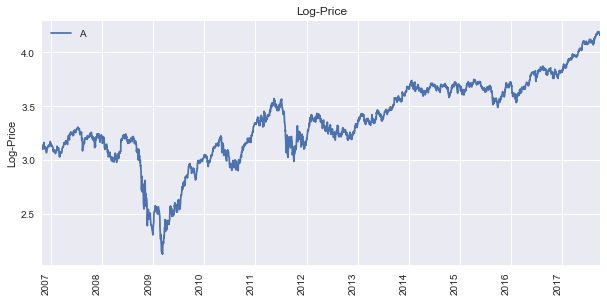

In [245]:
# define title
titleName='Log-Price'
# display the returns
logPrices['A'].plot(legend=True,figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Log-Price")


#### Example Plot of the Log-Return for Ticker 'A'

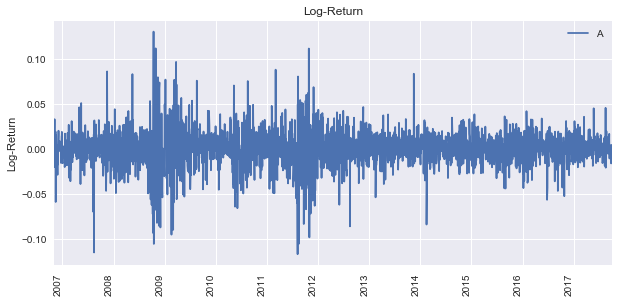

In [246]:
# define title
titleName='Log-Return'
# display the returns
logReturns['A'].plot(legend=True,figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Log-Return")


In [247]:
# Standardize the returns (i.e., remove the mean and 
# divide by the standard deviation):

# define standardization function
fStandardize=lambda x : x-numpy.mean(x)/numpy.std(x)
# standardize log returns
stdLogReturns=logReturns.apply(fStandardize,axis=1)

#### Example Plot of the Standardized Return for Ticker 'A'

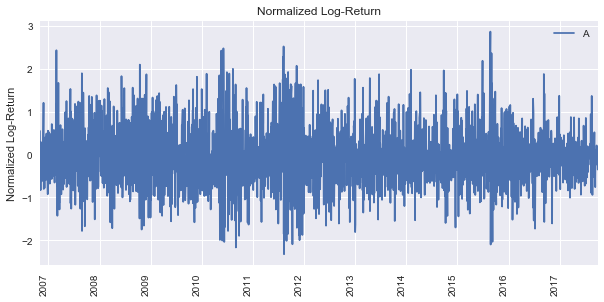

In [248]:
# define title
titleName='Normalized Log-Return'
stdLogReturns['A'].plot(legend=True,figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Normalized Log-Return")

In [249]:
# Extract standardized returns for approximately the last 2 years:

# compute the correlation matrix using d
recentStdLogReturns=stdLogReturns['2012-09-15':]

In [250]:
# Compute the rolling return correlations:

# define the size of the rolling window in days (roughly 2 years)
lookback=500
# compute the rolling correlations
rollingCorrelation=recentStdLogReturns.rolling(window=lookback,
    min_periods=lookback).corr(pairwise=True)

# It is important to note that computing 500-day rolling correlations 
# between 457 instruments produces an extremely noisey result. These 
# results are of little use in practice without employing methods to 
# improve the quality of the correlation estimates (using bootstrapping 
# for example). Employing such methods is beyond the scope of this project.


We can normalize for differing cross-sectional variability and create a price index that places emphasis on differences in price trends (drift).

In [251]:
# define standardization function where mean is retained
fStd=lambda x : x/numpy.std(x)
# standardize log returns
stdLogReturnsWithMean=logReturns.apply(fStd,axis=1)

#### Plot  of the Variability-Normalized Price Indices for the S&P500

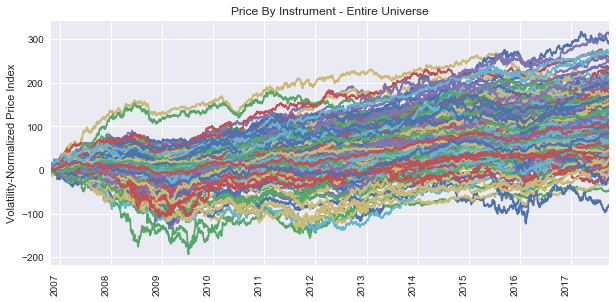

In [252]:
# define title
titleName='Price By Instrument - Entire Universe'
# create variability-normalized price index
standardizedLogPricesWithMean=stdLogReturnsWithMean.cumsum(axis=0)
# plot price index
standardizedLogPricesWithMean.plot(legend=False,figsize=(10,5),
    rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

After normalizing for variability, we can see that stocks in the S&P500 show a relatively high degree of co-movement. In many trading and risk management applications, we seek an approach for grouping stocks that move together. In the following sections, we will explore a sub-set of the S&P500 stock universe.

### Energy 

Now we focus on a smaller portion of our instrument universe, namely the 'Energy' sector.

In [253]:
gicsSectorName='Energy'
# create energy stock index
energyIndex=instrumentMaster['gicsSectorName']==gicsSectorName
# extract energy stock tickers
energyTickers=instrumentMaster['instrumentTicker'].loc[energyIndex].values
# extract instrument names
energy_instrumentNames=instrumentMaster['instrumentName'].loc[energyIndex].values
# extract GICs sub-industry names
energy_gicsSubIndustryName=instrumentMaster['gicsSubIndustryName'].loc[energyIndex].values

In [254]:
# Create a dictionary to lookup sub-industry by ticker:

# create dictionary
ticker2SubIndustry=dict()
# iterate over each ticker
for i in range(0,len(energyTickers)):
    # extract ticker
    ticker=energyTickers[i]
    # extract sub-industry
    subIndustry=energy_gicsSubIndustryName[i]
    # add sub-industry by ticker
    ticker2SubIndustry[ticker]=subIndustry

In [255]:
# We extract a small subset of the S&P500 instrument master for the energy stocks.

instrumentMaster.loc[energyIndex].groupby(['instrumentName',
    'instrumentTicker','gicsSubIndustryName'])['gicsSectorName'].count()

instrumentName               instrumentTicker  gicsSubIndustryName               
Anadarko Petroleum Corp      APC               Oil & Gas Exploration & Production    1
Andeavor                     ANDV              Oil & Gas Refining & Marketing        1
Apache Corporation           APA               Oil & Gas Exploration & Production    1
Cabot Oil & Gas              COG               Oil & Gas Exploration & Production    1
Chesapeake Energy            CHK               Oil & Gas Exploration & Production    1
Chevron Corp.                CVX               Integrated Oil & Gas                  1
Cimarex Energy               XEC               Oil & Gas Exploration & Production    1
ConocoPhillips               COP               Oil & Gas Exploration & Production    1
Devon Energy Corp.           DVN               Oil & Gas Exploration & Production    1
EOG Resources                EOG               Oil & Gas Exploration & Production    1
EQT Corporation              EQT               O

Given that the energy sector is composed of 6 sub-industries (see table  immediately below), we might expect to be able to detect clusters using the co-movement of stock prices within the sector.

In [256]:
instrumentMaster.loc[energyIndex].groupby(['gicsSectorName',
    'gicsSubIndustryName'])['gicsSubIndustryName'].count()

gicsSectorName  gicsSubIndustryName               
Energy          Integrated Oil & Gas                   3
                Oil & Gas Drilling                     1
                Oil & Gas Equipment & Services         4
                Oil & Gas Exploration & Production    15
                Oil & Gas Refining & Marketing         2
                Oil & Gas Storage & Transportation     2
Name: gicsSubIndustryName, dtype: int64

In [257]:
# Create a dictionary to map sub-industry to color:

subIndustry2Color={'Integrated Oil & Gas' : 'red',
    'Oil & Gas Drilling' : 'green',
    'Oil & Gas Equipment & Services' : 'blue',
    'Oil & Gas Exploration & Production' : 'cyan',
    'Oil & Gas Refining & Marketing' : 'magenta',
    'Oil & Gas Storage & Transportation' : 'yellow'}

Within the energy sector, stock prices appear to move roughly together, but with clear differences in mean and variability:

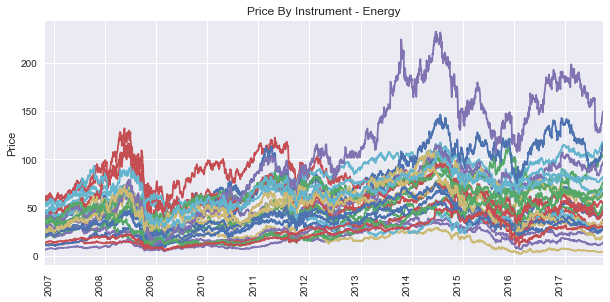

In [258]:
# define title
titleName='Price By Instrument - '+gicsSectorName
# plot prices
prices[energyTickers].plot(legend=False,figsize=(10,5),
    rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Price")

Once again, we can examine price indices normalized for differing cross-sectional variability.

We start by examining the entire 'Energy' sector sub-set of the S&P500, then we look at the stocks comprising each sub-industry. 

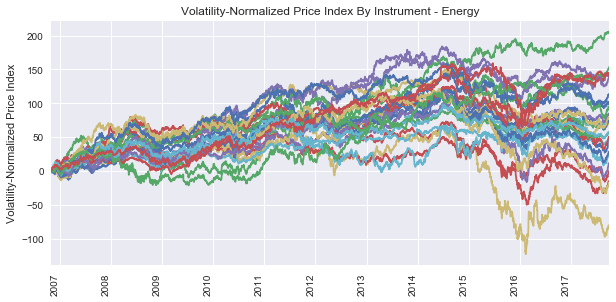

In [259]:
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSectorName
# extract standardized returns for energy stocks
energyStdLogReturnsWithMean=stdLogReturnsWithMean[energyTickers]
# create variability-normalized price index
energyStandardizedLogPricesWithMean=energyStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
energyStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

In [260]:
# Create indices and corresponding ticker lists for each energy sub-industry

# create 'Integrated Oil & Gas' index
integratedOilAndGasIndex=instrumentMaster['gicsSubIndustryName']=='Integrated Oil & Gas'
# create 'Oil & Gas Drilling' index
oilAndGasDrillingIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Drilling'
# create 'Oil & Gas Equipment & Services' index
oilAndGasEquipmentAndServicesIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Equipment & Services'
# create 'Oil & Gas Exploration & Production' index
oilAndGasExplorationAndProductionIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Exploration & Production'
# create 'Oil & Gas Refining & Marketing' index
oilAndGasRefiningAndMarketingIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Refining & Marketing'
# create 'Oil & Gas Exploration & Production' index
oilAndGasStorageAndTransportationIndex=instrumentMaster['gicsSubIndustryName']=='Oil & Gas Storage & Transportation'

# extract 'Integrated Oil & Gas' stock tickers
integratedOilAndGasTickers=instrumentMaster['instrumentTicker'].loc[integratedOilAndGasIndex].values
# extract 'Oil & Gas Drilling' stock tickers
oilAndGasDrillingTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasDrillingIndex].values
# extract 'Oil & Gas Equipment & Services' stock tickers
oilAndGasEquipmentAndServicesTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasEquipmentAndServicesIndex].values
# extract 'Oil & Gas Exploration & Production' stock tickers
oilAndGasExplorationAndProductionTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasExplorationAndProductionIndex].values
# extract 'Oil & Gas Refining & Marketing' stock tickers
oilAndGasRefiningAndMarketingTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasRefiningAndMarketingIndex].values
# extract 'Oil & Gas Storage & Transportation' stock tickers
oilAndGasStorageAndTransportationTickers=instrumentMaster['instrumentTicker'].loc[oilAndGasStorageAndTransportationIndex].values

#### 'Integrated Oil & Gas' Variability-Normalized Stock Price Indices

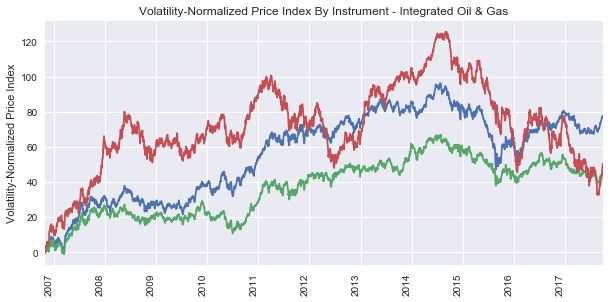

In [261]:
# set sub-industry name
gicsSubIndustryName='Integrated Oil & Gas'
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSubIndustryName
# extract standardized returns
integratedOilAndGasStdLogReturnsWithMean=stdLogReturnsWithMean[integratedOilAndGasTickers]
# create variability-normalized price index
integratedOilAndGasStandardizedLogPricesWithMean=integratedOilAndGasStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
integratedOilAndGasStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

#### 'Oil & Gas Drilling' Variability-Normalized Stock Price Indices

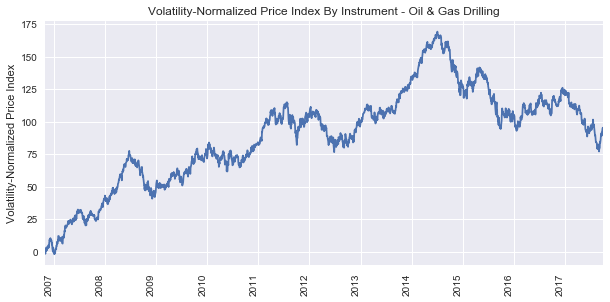

In [262]:
# set sub-industry name
gicsSubIndustryName='Oil & Gas Drilling'
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSubIndustryName
# extract standardized returns
oilAndGasDrillingStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasDrillingTickers]
# create variability-normalized price index
oilAndGasDrillingStandardizedLogPricesWithMean=oilAndGasDrillingStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasDrillingStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

#### 'Oil & Gas Equipment & Services' Variability-Normalized Stock Price Indices

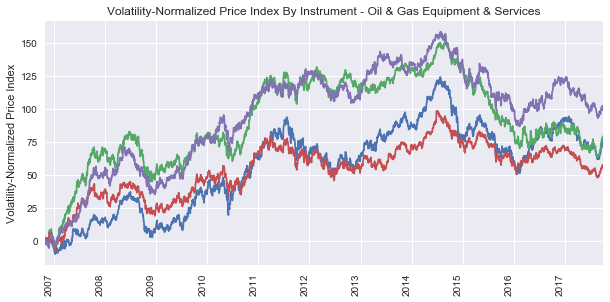

In [263]:
# set sub-industry name
gicsSubIndustryName='Oil & Gas Equipment & Services'
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSubIndustryName
# extract standardized returns
oilAndGasEquipmentAndServicesStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasEquipmentAndServicesTickers]
# create variability-normalized price index
oilAndGasEquipmentAndServicesStandardizedLogPricesWithMean=oilAndGasEquipmentAndServicesStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasEquipmentAndServicesStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

#### 'Oil & Gas Exploration & Production' Variability-Normalized Stock Price Indices

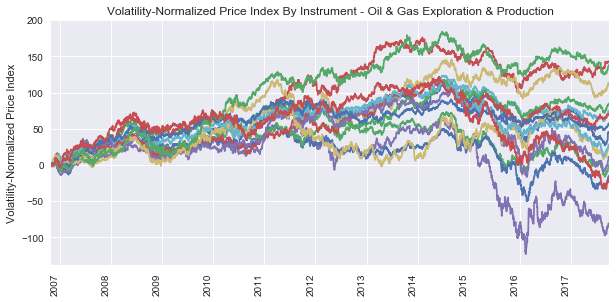

In [264]:
# set sub-industry name
gicsSubIndustryName='Oil & Gas Exploration & Production'
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSubIndustryName
# extract standardized returns
oilAndGasExplorationAndProductionStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasExplorationAndProductionTickers]
# create variability-normalized price index
oilAndGasExplorationAndProductionStandardizedLogPricesWithMean=oilAndGasExplorationAndProductionStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasExplorationAndProductionStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

#### 'Oil & Gas Refining & Marketing' Variability-Normalized Stock Price Indices

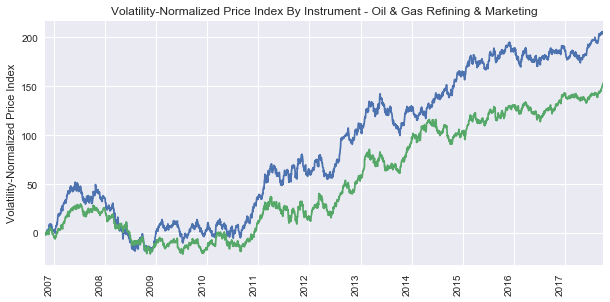

In [265]:
# set sub-industry name
gicsSubIndustryName='Oil & Gas Refining & Marketing'
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSubIndustryName
# extract standardized returns
oilAndGasRefiningAndMarketingStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasRefiningAndMarketingTickers]
# create variability-normalized price index
oilAndGasRefiningAndMarketingStandardizedLogPricesWithMean=oilAndGasRefiningAndMarketingStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasRefiningAndMarketingStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

#### 'Oil & Gas Storage & Transportation' Variability-Normalized Stock Price Index

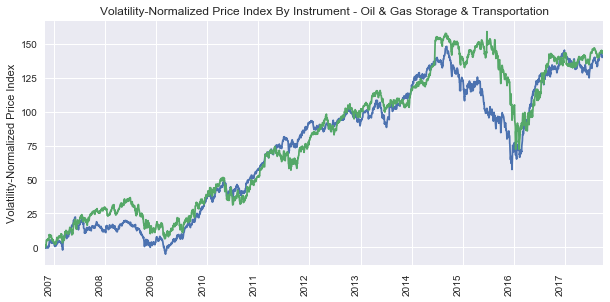

In [266]:
# set sub-industry name
gicsSubIndustryName='Oil & Gas Storage & Transportation'
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSubIndustryName
# extract standardized returns
oilAndGasStorageAndTransportationStdLogReturnsWithMean=stdLogReturnsWithMean[oilAndGasStorageAndTransportationTickers]
# create variability-normalized price index
oilAndGasStorageAndTransportationStandardizedLogPricesWithMean=oilAndGasStorageAndTransportationStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
oilAndGasStorageAndTransportationStandardizedLogPricesWithMean.plot(legend=False,
    figsize=(10,5),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

In [267]:
# extract standardized returns for energy stocks
energyStdLogReturns=stdLogReturns[energyTickers]

In [268]:
# Compute rolling log return correlations using a roughly 1-year lookback

# define the size of the rolling window in days
lookback=250
# compute the rolling correlations
energyCorrelations=energyStdLogReturns.rolling(window=lookback,
    min_periods=lookback).corr(pairwise=True)

Based on the plots of the normalized price indices above, it is apparent that there is some co-movement among 'Energy' stocks in the S&P500, but it is not easy to determine a hierarchical structure that could be exploited in practical applications based on these visualizations alone. There does appear to be a significant amount of co-movement along sub-industry lines.

##  Correlation Networks

Using log-return correlation we obtain a set of $n \times (n-1)/2$ numbers characterizing the similarity of any of the $n$ stocks with respect to all the other $n-1$ stocks. This set of numbers forms a complete graph with different edge strengths given by the correlation value. To every entry of the correlation matrix we can associate a metric distance between any pair of stocks by defining

$$d_{i,j}(\Delta t)=\sqrt{2(1-\rho_{i,j}(\Delta t))}$$

$d_{i,j}(\Delta t)$ fulfils the following three axioms of a metric distance:

1) $d_{i,j}(\Delta t)=0$ if and only if $i=j$;

2) $d_{i,j}(\Delta t)=d_{i,j}(\Delta t) \forall i,j$;

3) $d_{i,j}(\Delta t) \le d_{i,k}(\Delta t) + d_{k,j}(\Delta t) \forall i,j,k$

This distance matrix $D(\Delta t)$ will be used in a later section to determine the Minimum Spanning Tree (MST) connecting the $n$ stocks in the instrument universe under study.

This distance metric is used to create our graph below.

In [269]:
# create correlation graph
energy_G=networkx.Graph()
# number of periods
nPeriods=len(energyCorrelations)
# extract the correlation matrix for the last date ('2017-09-15 00:00:00')
energy_C=energyCorrelations.loc[('2017-09-15 00:00:00', energyTickers)]
# extract the correlation matrix to a numpy array
rho=energy_C.values
# number of sector instruments
nEnergyInstruments=len(energyTickers)
# iterate over each instrument
for i in range(0,nEnergyInstruments):
    # define ticker [i]
    iTicker=energyTickers[i]
    # iterate over each instrument
    for j in range(0,nEnergyInstruments):
        # define ticker [j]
        jTicker=energyTickers[j]
        # compute distance
        metricDistance=math.sqrt(2.0*(1.0-round(rho[i,j],10)))
        # build network
        energy_G.add_edge(iTicker,jTicker,weight=metricDistance)
        
# set color attributes for network nodes
for n in energy_G.nodes():
    energy_G.node[n]['color']=subIndustry2Color[ticker2SubIndustry[n]]

In [270]:
# determine number of nodes
energy_nNodes=energy_G.number_of_nodes()
# display number of nodes
#energy_nNodes

In [271]:
# determine number of edges
energy_nEdges=energy_G.number_of_edges()
# display number of edges
#energy_nEdges

Our small network has just 27 nodes and 378 edges.

We create the visualization of the correlation network graph using the distance metric defined above.

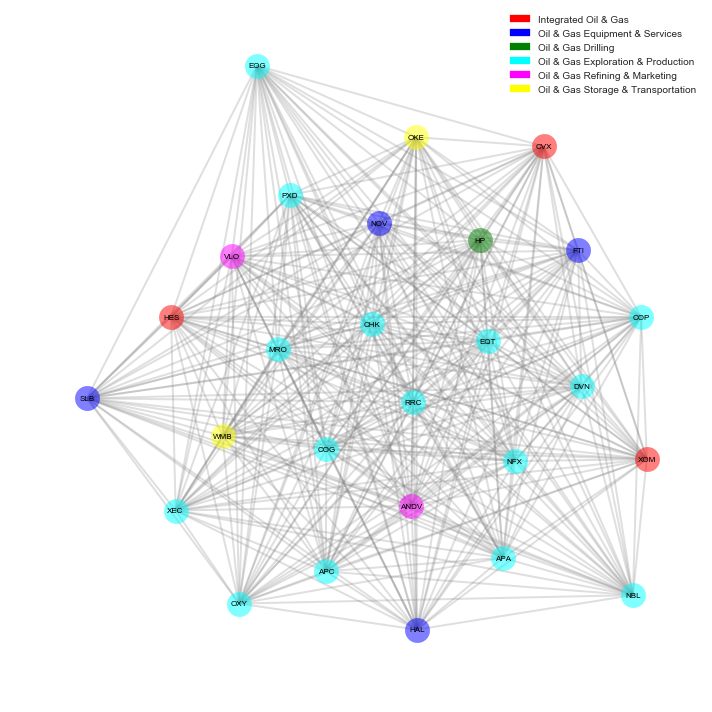

In [272]:
plt.figure(figsize=(10,10))

# determine the positions using spring layout
energy_position=networkx.spring_layout(energy_G)

# add nodes
for n in energy_G.nodes():
    networkx.draw_networkx_nodes(energy_G, energy_position, 
    [n], node_size = 600,node_color=energy_G.node[n]['color'],
    with_labels=True,alpha=0.5)

# add edges
networkx.draw_networkx_edges(energy_G,pos=energy_position,edge_color='grey',
    alpha=0.25,width=2)

# add labels
networkx.draw_networkx_labels(energy_G,pos=energy_position,font_size=8)
# remove axis
plt.axis('off')
# define legend patches for each sub-industry
red_patch = mpatches.Patch(color='red', label='Integrated Oil & Gas')
blue_patch = mpatches.Patch(color='blue', label='Oil & Gas Equipment & Services')
green_patch = mpatches.Patch(color='green', label='Oil & Gas Drilling')
cyan_patch = mpatches.Patch(color='cyan', label='Oil & Gas Exploration & Production')
magenta_patch = mpatches.Patch(color='magenta', label='Oil & Gas Refining & Marketing')
yellow_patch = mpatches.Patch(color='yellow', label='Oil & Gas Storage & Transportation')
# add legend
plt.legend(handles=[red_patch, blue_patch,green_patch,cyan_patch,
    magenta_patch,yellow_patch])
# set tight layout
plt.tight_layout()
# display the graph
plt.show()

Color in the above network graph indicates sub-industry.

Prior to any filtering of the correlation network, our visualization does not reveal much about the structure of the network under study.

## Centrality Measures

In this section, we will look at centrality metrics before and after applying Prim's algorithm to transform our correlation network to its corresponding minimal spanning tree equivalent.

### Weighted Degree

[Define degree]

In [273]:
# compute weighted degree
energy_degreeByInstrument=networkx.degree(energy_G,weight='weight')
# convert degree dictionary to dataframe
energy_degreeByInstrumentDf=pandas.DataFrame.from_dict(energy_degreeByInstrument,
    orient='index')
# rename column
energy_degreeByInstrumentDf.rename(columns={0 : 'degree'},inplace=True)
# join degree and instrument master (by ticker)
energy_degreeByInstrumentTable=pandas.merge(energy_degreeByInstrumentDf, 
    instrumentMaster, how='inner', left_index=True, right_on='instrumentTicker')
# display result
energy_degreeByInstrumentTable.sort_values(ascending=False,
    by=['degree','gicsSubIndustryName'])

,degree,instrumentTicker,instrumentName,gicsSectorName,gicsSubIndustryName
105,1.598479,CHK,Chesapeake Energy,Energy,Oil & Gas Exploration & Production
392,1.592295,RRC,Range Resources Corp.,Energy,Oil & Gas Exploration & Production
86,1.483196,COG,Cabot Oil & Gas,Energy,Oil & Gas Exploration & Production
297,1.373814,MRO,Marathon Oil Corp.,Energy,Oil & Gas Exploration & Production
44,1.369587,ANDV,Andeavor,Energy,Oil & Gas Refining & Marketing
468,1.359416,VLO,Valero Energy,Energy,Oil & Gas Refining & Marketing
177,1.345247,EQT,EQT Corporation,Energy,Oil & Gas Exploration & Production
334,1.272181,NFX,Newfield Exploration Co,Energy,Oil & Gas Exploration & Production
232,1.228331,HP,Helmerich & Payne,Energy,Oil & Gas Drilling
492,1.205959,WMB,Williams Cos.,Energy,Oil & Gas Storage & Transportation


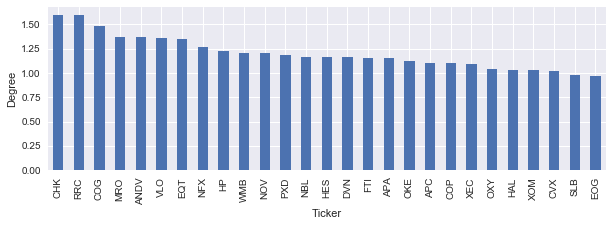

In [274]:
# Plot the weighted degree
plt.figure(figsize=(10,3))
energy_degreeByInstrumentDf=pandas.DataFrame(energy_degreeByInstrument,
    index=energy_degreeByInstrument.keys()).iloc[0]
energy_degreeByInstrumentDf.sort_values(ascending=False).plot('bar')
plt.ylabel("Degree")
plt.xlabel("Ticker")

### Eigenvector Centrality

Eigenvector centrality is a spectral centrality measure, based on the spectral properties of the adjacency matrix, $A$.

We define the centrality of a node (vertex) $i$ as the average of the entrality of its neighbours:

$$c_{i}=\frac{1}{\lambda}\sum_{j=1,N}{a_{ij}c_{j}}$$

The above equation can be written in vectorial form as:

$$Ac=\lambda c$$

This measure of centrality is an eigenvector of the adjacency matrix, $A$, where $\lambda$ and $c$ are the corresponding eigenvalue and eigenvector respectively.

If if the graph is (strongly) connected (or equivalently, $A$ is irreducible) then the eigenvector, $c$, is both unique and positive.

Using this measure, nodes are deemed central if they are connected to other highly central nodes.

In [275]:
# compute weighted eigenvector centrality
energy_eigenvectorCentrality = networkx.eigenvector_centrality(energy_G,weight='weight')
# convert degree dictionary to dataframe
energy_eigenvectorCentralityDf=pandas.DataFrame.from_dict(energy_eigenvectorCentrality,
    orient='index')
# rename column
energy_eigenvectorCentralityDf.rename(columns={0 : 'eigenvectorCentrality'},
    inplace=True)
# join degree and instrument master (by ticker)
energy_eigenvectorCentralityByInstrumentTable=pandas.merge(energy_eigenvectorCentralityDf, 
    instrumentMaster, how='inner', left_index=True, right_on='instrumentTicker')
# display sorted result
energy_eigenvectorCentralityByInstrumentTable.sort_values(ascending=False,
    by=['eigenvectorCentrality','gicsSubIndustryName'])

,eigenvectorCentrality,instrumentTicker,instrumentName,gicsSectorName,gicsSubIndustryName
105,0.247009,CHK,Chesapeake Energy,Energy,Oil & Gas Exploration & Production
392,0.245476,RRC,Range Resources Corp.,Energy,Oil & Gas Exploration & Production
86,0.230251,COG,Cabot Oil & Gas,Energy,Oil & Gas Exploration & Production
297,0.216462,MRO,Marathon Oil Corp.,Energy,Oil & Gas Exploration & Production
44,0.215213,ANDV,Andeavor,Energy,Oil & Gas Refining & Marketing
468,0.213826,VLO,Valero Energy,Energy,Oil & Gas Refining & Marketing
177,0.210129,EQT,EQT Corporation,Energy,Oil & Gas Exploration & Production
334,0.200579,NFX,Newfield Exploration Co,Energy,Oil & Gas Exploration & Production
232,0.195003,HP,Helmerich & Payne,Energy,Oil & Gas Drilling
492,0.191657,WMB,Williams Cos.,Energy,Oil & Gas Storage & Transportation


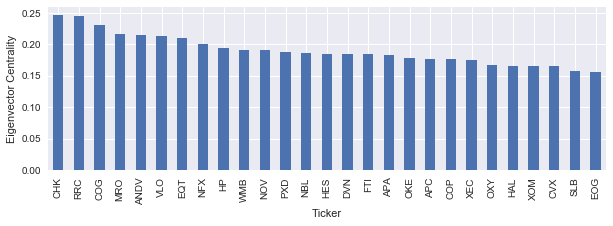

In [276]:
plt.figure(figsize=(10,3))
energy_eigenvectorCentralityByInstrumentDf=pandas.DataFrame(energy_eigenvectorCentrality,
    index=energy_eigenvectorCentrality.keys()).iloc[0]
energy_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).plot('bar')
plt.ylabel("Eigenvector Centrality")
plt.xlabel("Ticker")

There appears to be a significant overlap in the rankings of the 'Energy' sector stocks by weighted degree and eigenvector centrality. These rankings, however, are not easily interpreted. There are only small differences across stocks in the sector for both degree and eigenvector centrality.

### Minimum Spanning Tree

In the following section, we filter the energy correlation network using Prim's algorithm to create the minimal spanning tree (MST).

We create the minimal spanning tree (MST) representation of the energy stock correlation network and plot the minimum spanning tree (MST).

In [277]:
energy_tree_seed=energyTickers[0]
energy_N_new=[]
energy_E_new=[]
energy_N_new.append(energy_tree_seed)
while len(energy_N_new) < energy_G.number_of_nodes():
    min_weight=10000000.0
    for n in energy_N_new:
        for n_adj in energy_G.neighbors(n):
            if not n_adj in energy_N_new:
                if energy_G[n][n_adj]['weight'] < min_weight:
                    min_weight=energy_G[n][n_adj]['weight']
                    min_weight_edge=(n,n_adj)
                    n_adj_ext=n_adj
    energy_E_new.append(min_weight_edge)
    energy_N_new.append(n_adj_ext)
    
# generate tree from edge list
energy_tree_graph=networkx.Graph()
energy_tree_graph.add_edges_from(energy_E_new)

# set color attributes for network nodes
for n in energy_tree_graph.nodes():
    energy_tree_graph.node[n]['color']=subIndustry2Color[ticker2SubIndustry[n]]


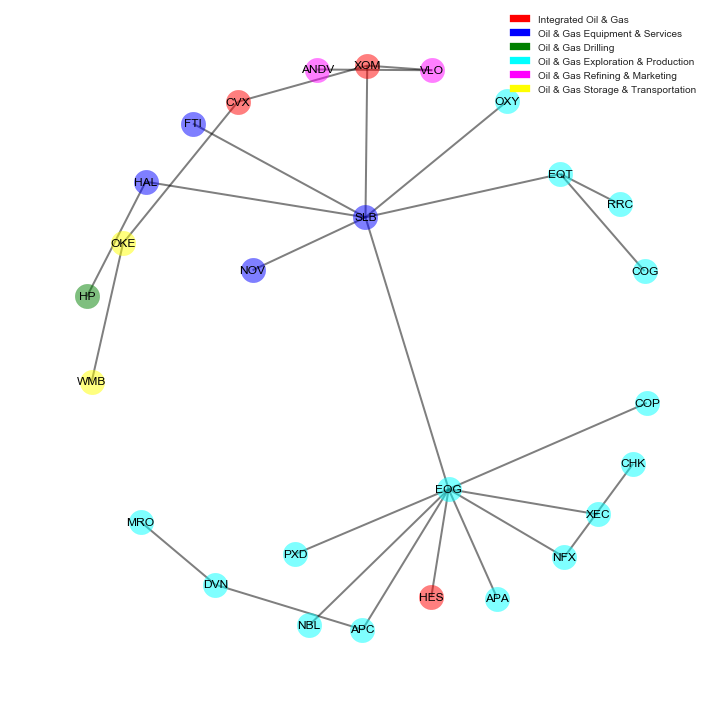

In [302]:
# create position
energy_pos=networkx.spring_layout(energy_tree_graph)
# create figure
plt.figure(figsize=(10,10))
# add edges
networkx.draw_networkx_edges(energy_tree_graph,energy_pos,width=2, 
    edge_color='black', alpha=0.5, style="solid")
# add labels
networkx.draw_networkx_labels(energy_tree_graph,energy_pos)
# add nodes
for n in energy_tree_graph.nodes():
    networkx.draw_networkx_nodes(energy_tree_graph, energy_pos, 
    [n], node_size = 600,node_color=energy_tree_graph.node[n]['color'],
    with_labels=True,alpha=0.5)
# remove axis
plt.axis('off')
# define legend patches for each sub-industry
red_patch = mpatches.Patch(color='red', label='Integrated Oil & Gas')
blue_patch = mpatches.Patch(color='blue', label='Oil & Gas Equipment & Services')
green_patch = mpatches.Patch(color='green', label='Oil & Gas Drilling')
cyan_patch = mpatches.Patch(color='cyan', label='Oil & Gas Exploration & Production')
magenta_patch = mpatches.Patch(color='magenta', label='Oil & Gas Refining & Marketing')
yellow_patch = mpatches.Patch(color='yellow', label='Oil & Gas Storage & Transportation')
# add legend
plt.legend(handles=[red_patch, blue_patch,green_patch,cyan_patch,
    magenta_patch,yellow_patch])
# set tight layout
plt.tight_layout()
# display the graph
plt.show()

Based on the minimum spanning tree, we can identify hubs and clusters that - at least partially - align with our sub-industry categorical variable, sub-industry.

The minimum spanning tree shows a large number of stocks having a single link, while other stocks have several links. Some of these stocks act as the "hub" of a local cluster. For instance, EOG Resources Inc. (EOG) appears to be central to the movement of stocks within the 'Energy' sector, particularly within the largest sub-industry, 'Oil & Gas Exploration & Production'.

Within the energy sector, Schlumberger Ltd. (SLB) also appears to be central, with a degree nearly as high as EOG Resources Inc (see table below).

Based on the minimum spanning tree, it appears as though EOG Resources Inc. and Schlumberger Ltd. could be major drivers of co-movement within the energy sector.

In [279]:
# compute weighted degree
energy_degreeByInstrumentMST=networkx.degree(energy_tree_graph,weight='weight')
# display
energy_degreeByInstrumentMST

# [join with instrument master]
# compute weighted degree
gicsSector_degreeByInstrumentMST=networkx.degree(gicsSector_tree_graph,
    weight='weight')
# convert degree dictionary to dataframe
energy_degreeByInstrumentMstDf=pandas.DataFrame.from_dict(energy_degreeByInstrumentMST,
    orient='index')
# rename column
energy_degreeByInstrumentMstDf.rename(columns={0 : 'degree'},inplace=True)
# join degree and instrument master (by ticker)
energy_degreeByInstrumentMstTable=pandas.merge(energy_degreeByInstrumentMstDf, 
    instrumentMaster, how='inner', left_index=True, right_on='instrumentTicker')
# display result
energy_degreeByInstrumentMstTable.sort_values(ascending=False,
    by=['degree','gicsSubIndustryName'])

,degree,instrumentTicker,instrumentName,gicsSectorName,gicsSubIndustryName
176,9,EOG,EOG Resources,Energy,Oil & Gas Exploration & Production
411,7,SLB,Schlumberger Ltd.,Energy,Oil & Gas Equipment & Services
177,3,EQT,EQT Corporation,Energy,Oil & Gas Exploration & Production
190,3,XOM,Exxon Mobil Corp.,Energy,Integrated Oil & Gas
353,2,OKE,ONEOK,Energy,Oil & Gas Storage & Transportation
468,2,VLO,Valero Energy,Energy,Oil & Gas Refining & Marketing
149,2,DVN,Devon Energy Corp.,Energy,Oil & Gas Exploration & Production
334,2,NFX,Newfield Exploration Co,Energy,Oil & Gas Exploration & Production
42,2,APC,Anadarko Petroleum Corp,Energy,Oil & Gas Exploration & Production
224,2,HAL,Halliburton Co.,Energy,Oil & Gas Equipment & Services


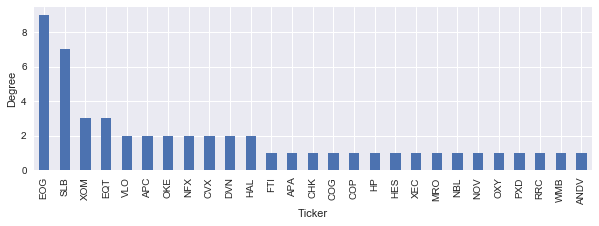

In [280]:
plt.figure(figsize=(10,3))
energy_degreeByInstrumentMSTDf=pandas.DataFrame(energy_degreeByInstrumentMST,
    index=energy_degreeByInstrumentMST.keys()).iloc[0]
energy_degreeByInstrumentMSTDf.sort_values(ascending=False).plot('bar')
plt.ylabel("Degree")
plt.xlabel("Ticker")

Notice that we now observe a single stock - EOG Resources Inc. (EOG) - with a degree of 9. None of the stocks in the top 5 for either the weighted degree or eigenvector centrality of the unfiltered return correlation network appear significant based on the minimal spanning tree (MST) representation of the graph. In fact, the stocks with the top 5 weighted degrees of the minimal spanning tree (MST) are in the bottom of the eigenvector centrality ranking. We also observe more alignment between our sub-industry categorial variable and the identified clusters.

## Conclusion

Prior to any filtering of the log-return correlation network, it was difficult to find clear relationships between stocks using common centrality metrics. Metrics such as weighted degree and eigenvector centrality provided only limited information about the structure of the network prior to filtering. 

We construct a minimum spanning tree (MST) and reexamine weighted degree. After such filtering of the log-return correlation network, we can identify hubs and clusters that - at least partially - align with our sub-industry categorical variable. 

We can identify both stocks that tend to be central to common movement among groups of stocks within the universe under study, and diversifying stocks that appear to be driven predominately by uncommon (specific) factors. Additional categorical variables - such as capitalization, known large customer lists, or accounting statement data - might help improve our understanding of the identified hubs.

The minimum spanning tree representation of the log-return correlation network provides a hierarchical classification system that can potentially be used to identify relatively homogeneous baskets of stocks that can be considered 'similar' for the purposes of risk management.

## Appendix

The following sections of this Appendix provide some of the exploratory work that was done while scoping out the proposed project. More specifically, in this section we take a more generic approach to exploring correlation network of a particular sector.

Set the variable 'gicsSectorName' to explore other sectors.

In [281]:
#gicsSectorName='Information Technology'
#gicsSectorName='Utilities'
gicsSectorName='Health Care'
# create energy stock index
gicsSectorIndex=instrumentMaster['gicsSectorName']==gicsSectorName
# extract energy stock tickers
gicsSectorTickers=instrumentMaster['instrumentTicker'].loc[gicsSectorIndex].values
# extract instrument names
sector_instrumentNames=instrumentMaster['instrumentName'].loc[gicsSectorIndex].values
# extract GICs sub-industry names
sector_gicsSubIndustryName=instrumentMaster['gicsSubIndustryName'].loc[gicsSectorIndex].values

In [282]:
# create dictionary
ticker2SubIndustry=dict()
# iterate over each ticker
for i in range(0,len(gicsSectorTickers)):
    # extract ticker
    ticker=gicsSectorTickers[i]
    # extract sub-industry
    subIndustry=sector_gicsSubIndustryName[i]
    # add sub-industry by ticker
    ticker2SubIndustry[ticker]=subIndustry

Show stocks within the sector:

In [283]:
instrumentMaster.loc[gicsSectorIndex].groupby(['instrumentName',
    'instrumentTicker','gicsSubIndustryName'])['gicsSectorName'].count()

instrumentName                       instrumentTicker  gicsSubIndustryName           
Abbott Laboratories                  ABT               Health Care Equipment             1
Aetna Inc                            AET               Managed Health Care               1
Agilent Technologies Inc             A                 Health Care Equipment             1
Alexion Pharmaceuticals              ALXN              Biotechnology                     1
Align Technology                     ALGN              Health Care Supplies              1
Allergan, Plc                        AGN               Pharmaceuticals                   1
AmerisourceBergen Corp               ABC               Health Care Distributors          1
Amgen Inc                            AMGN              Biotechnology                     1
Anthem Inc.                          ANTM              Managed Health Care               1
Bard (C.R.) Inc.                     BCR               Health Care Equipment             1
Baxt

Count the number of stocks by sub-industry:

In [284]:
instrumentMaster.loc[gicsSectorIndex].groupby(['gicsSectorName',
    'gicsSubIndustryName'])['gicsSubIndustryName'].count()

gicsSectorName  gicsSubIndustryName           
Health Care     Biotechnology                      8
                Health Care Distributors           7
                Health Care Equipment             19
                Health Care Facilities             2
                Health Care Services               2
                Health Care Supplies               4
                Health Care Technology             1
                Life Sciences Tools & Services     2
                Managed Health Care                6
                Pharmaceuticals                    6
Name: gicsSubIndustryName, dtype: int64

In [285]:
# find unique sub-industries within sector
unique_sector_gicsSubIndustryName=numpy.unique(sector_gicsSubIndustryName)
# find number of sub-industries within sector
nGicsSubIndustry=len(unique_sector_gicsSubIndustryName)
# set color map
colorList=seaborn.color_palette("RdBu_r", nGicsSubIndustry)
# define dictionary mapping sub-industry to color
subIndustry2Color=dict()
# define sub-industry n
nGicsSubIndustry=len(unique_sector_gicsSubIndustryName)
# iterate over sub-industry
for iSubIndustry in range(0,nGicsSubIndustry):
    # assign color for sub-industry
    subIndustry2Color[unique_sector_gicsSubIndustryName[iSubIndustry]]=colorList[iSubIndustry]

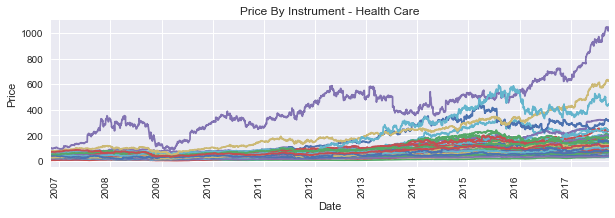

In [286]:
# define title
titleName='Price By Instrument - '+gicsSectorName
# plot price
prices[gicsSectorTickers].plot(legend=False,figsize=(10,3),
    rot=90,title=titleName)
# set y-label
plt.ylabel("Price")

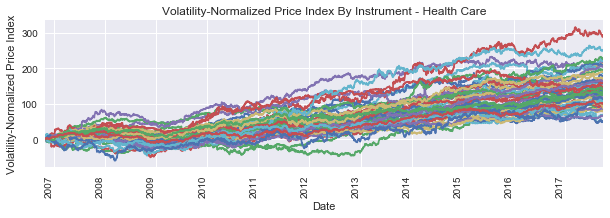

In [287]:
# define title
titleName='Volatility-Normalized Price Index By Instrument - '+gicsSectorName
# extract standardized returns for energy stocks
gicsSectorStdLogReturnsWithMean=stdLogReturnsWithMean[gicsSectorTickers]
# create variability-normalized price index
gicsSectorStandardizedLogPricesWithMean=gicsSectorStdLogReturnsWithMean.cumsum(axis=0)
# plot price index
gicsSectorStandardizedLogPricesWithMean.plot(legend=False,figsize=(10,3),
    rot=90,title=titleName)
# set y-label
plt.ylabel("Volatility-Normalized Price Index")

In [288]:
# extract standardized returns for sector stocks
gicsSectorStdLogReturns=stdLogReturns[gicsSectorTickers]

In [289]:
# define the size of the rolling window in days
lookback=250
# compute the rolling correlations
gicsSectorCorrelations=gicsSectorStdLogReturns.rolling(window=lookback,
    min_periods=lookback).corr(pairwise=True)

In [290]:
# find number of tickers in sector (GICS)
nGicsSectorInstruments=len(gicsSectorTickers)
# create correlation graph
gicsSector_G=networkx.Graph()
import math
# number of periods
nPeriods=len(gicsSectorCorrelations)
# extract the correlation matrix for the last date ('2017-09-15 00:00:00')
gicsSector_C=gicsSectorCorrelations.loc[('2017-09-15 00:00:00', gicsSectorTickers)]
# extract the correlation matrix to a numpy array
rho=gicsSector_C.values
# iterate over each instrument
for i in range(0,nGicsSectorInstruments):
    # define ticker [i]
    iTicker=gicsSectorTickers[i]
    # iterate over each instrument
    for j in range(0,nGicsSectorInstruments):
        # define ticker [j]
        jTicker=gicsSectorTickers[j]
        # compute distance
        metricDistance=math.sqrt(2.0*(1.0-round(rho[i,j],10)))
        # build network
        gicsSector_G.add_edge(iTicker,jTicker,weight=metricDistance)
        
# set color attributes for network nodes
for n in gicsSector_G.nodes():
    gicsSector_G.node[n]['color']=subIndustry2Color[ticker2SubIndustry[n]]

In [291]:
# determine number of nodes
gicsSector_nNodes=gicsSector_G.number_of_nodes()
# display number of nodes
gicsSector_nNodes

57

In [292]:
# determine number of edges
gicsSector_nEdges=gicsSector_G.number_of_edges()
# display number of edges
gicsSector_nEdges

1653

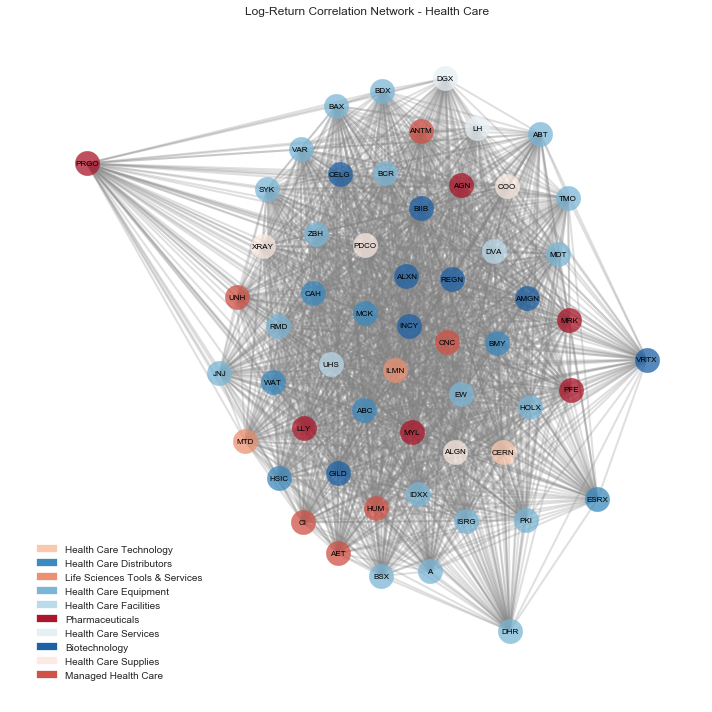

In [293]:
# define title
titleName='Log-Return Correlation Network - '+gicsSectorName
# set figure size
plt.figure(figsize=(10,10))
# add title
plt.title(titleName)
# determine the positions using spring layout
gicsSector_position=networkx.spring_layout(gicsSector_G)

# add nodes
for n in gicsSector_G.nodes():
    networkx.draw_networkx_nodes(gicsSector_G, gicsSector_position, 
    [n], node_size = 600,node_color=gicsSector_G.node[n]['color'],
    with_labels=True,alpha=0.75)

# add edges
networkx.draw_networkx_edges(gicsSector_G,pos=gicsSector_position,
    edge_color='grey',alpha=0.25,width=2)

# add labels
networkx.draw_networkx_labels(gicsSector_G,pos=gicsSector_position,
    font_size=8)
# remove axis
plt.axis('off')
# add legend
legend_color_patch=list()
# iterate over sub-industry and create patches
for subIndustryName in subIndustry2Color.keys():
    subIndustryColor=subIndustry2Color[subIndustryName]
    color_patch=mpatches.Patch(color=subIndustryColor, 
        label=subIndustryName)
    legend_color_patch.append(color_patch)
# add legend
plt.legend(handles=legend_color_patch)
# set tight layout
plt.tight_layout()
# display the graph
plt.show()

In [294]:
# compute weighted degree
gicsSector_degreeByInstrument=networkx.degree(gicsSector_G,
    weight='weight')
# convert degree dictionary to dataframe
gicsSector_degreeByInstrumentDf=pandas.DataFrame.from_dict(gicsSector_degreeByInstrument,
    orient='index')
# rename column
gicsSector_degreeByInstrumentDf.rename(columns={0 : 'degree'},inplace=True)
# join degree and instrument master (by ticker)
degreeByInstrumentTable=pandas.merge(gicsSector_degreeByInstrumentDf, 
    instrumentMaster, how='inner', left_index=True, right_on='instrumentTicker')
# display result
degreeByInstrumentTable.sort_values(ascending=False,
    by=['degree','gicsSubIndustryName'])

,degree,instrumentTicker,instrumentName,gicsSectorName,gicsSubIndustryName
249,3.748390,ILMN,Illumina Inc,Health Care,Life Sciences Tools & Services
474,3.670987,VRTX,Vertex Pharmaceuticals Inc,Health Care,Biotechnology
19,3.655195,ALXN,Alexion Pharmaceuticals,Health Care,Biotechnology
254,3.649911,INCY,Incyte,Health Care,Biotechnology
365,3.388231,PRGO,Perrigo,Health Care,Pharmaceuticals
98,3.379693,CNC,Centene Corporation,Health Care,Managed Health Care
307,3.317794,MCK,McKesson Corp.,Health Care,Health Care Distributors
398,3.125796,REGN,Regeneron,Health Care,Biotechnology
38,2.980813,ABC,AmerisourceBergen Corp,Health Care,Health Care Distributors
171,2.979756,EW,Edwards Lifesciences,Health Care,Health Care Equipment


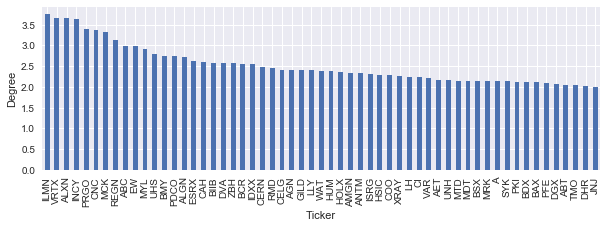

In [295]:
plt.figure(figsize=(10,3))
gicsSector_degreeByInstrumentDf=pandas.DataFrame(gicsSector_degreeByInstrument,
    index=gicsSector_degreeByInstrument.keys()).iloc[0]
gicsSector_degreeByInstrumentDf.sort_values(ascending=False).plot('bar')
plt.ylabel("Degree")
plt.xlabel("Ticker")

In [296]:
# compute weighted eigenvector centrality
gicsSector_eigenvectorCentrality = networkx.eigenvector_centrality(gicsSector_G,
    weight='weight')
# convert degree dictionary to dataframe
gicsSector_eigenvectorCentralityDf=pandas.DataFrame.from_dict(gicsSector_eigenvectorCentrality,
    orient='index')
# rename column
gicsSector_eigenvectorCentralityDf.rename(columns={0 : 'eigenvectorCentrality'},
    inplace=True)
# join degree and instrument master (by ticker)
eigenvectorCentralityByInstrumentTable=pandas.merge(gicsSector_eigenvectorCentralityDf, 
    instrumentMaster, how='inner', left_index=True, right_on='instrumentTicker')
# display result
eigenvectorCentralityByInstrumentTable.sort_values(ascending=False,
    by=['eigenvectorCentrality','gicsSubIndustryName'])


,eigenvectorCentrality,instrumentTicker,instrumentName,gicsSectorName,gicsSubIndustryName
249,0.188972,ILMN,Illumina Inc,Health Care,Life Sciences Tools & Services
474,0.184683,VRTX,Vertex Pharmaceuticals Inc,Health Care,Biotechnology
19,0.184200,ALXN,Alexion Pharmaceuticals,Health Care,Biotechnology
254,0.183640,INCY,Incyte,Health Care,Biotechnology
98,0.172112,CNC,Centene Corporation,Health Care,Managed Health Care
365,0.171548,PRGO,Perrigo,Health Care,Pharmaceuticals
307,0.168069,MCK,McKesson Corp.,Health Care,Health Care Distributors
398,0.158523,REGN,Regeneron,Health Care,Biotechnology
171,0.152875,EW,Edwards Lifesciences,Health Care,Health Care Equipment
38,0.151590,ABC,AmerisourceBergen Corp,Health Care,Health Care Distributors


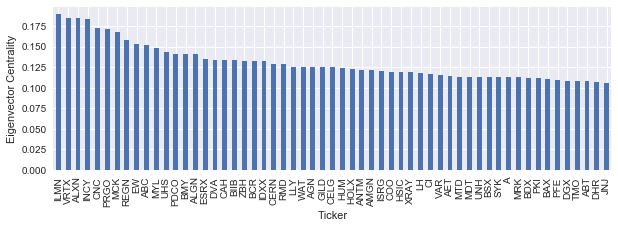

In [297]:
plt.figure(figsize=(10,3))
gicsSector_eigenvectorCentralityByInstrumentDf=pandas.DataFrame(gicsSector_eigenvectorCentrality,
    index=gicsSector_eigenvectorCentrality.keys()).iloc[0]
gicsSector_eigenvectorCentralityByInstrumentDf.sort_values(ascending=False).plot('bar')
plt.ylabel("Eigenvector Centrality")
plt.xlabel("Ticker")


In [298]:
gicsSector_tree_seed=gicsSectorTickers[0]
gicsSector_N_new=[]
gicsSector_E_new=[]
gicsSector_N_new.append(gicsSector_tree_seed)
while len(gicsSector_N_new) < gicsSector_G.number_of_nodes():
    min_weight=10000000.0
    for n in gicsSector_N_new:
        for n_adj in gicsSector_G.neighbors(n):
            if not n_adj in gicsSector_N_new:
                if gicsSector_G[n][n_adj]['weight'] < min_weight:
                    min_weight=gicsSector_G[n][n_adj]['weight']
                    min_weight_edge=(n,n_adj)
                    n_adj_ext=n_adj
    gicsSector_E_new.append(min_weight_edge)
    gicsSector_N_new.append(n_adj_ext)
    
# generate tree from edge list
gicsSector_tree_graph=networkx.Graph()
gicsSector_tree_graph.add_edges_from(gicsSector_E_new)

# set color attributes for network nodes
for n in gicsSector_tree_graph.nodes():
    gicsSector_tree_graph.node[n]['color']=subIndustry2Color[ticker2SubIndustry[n]]

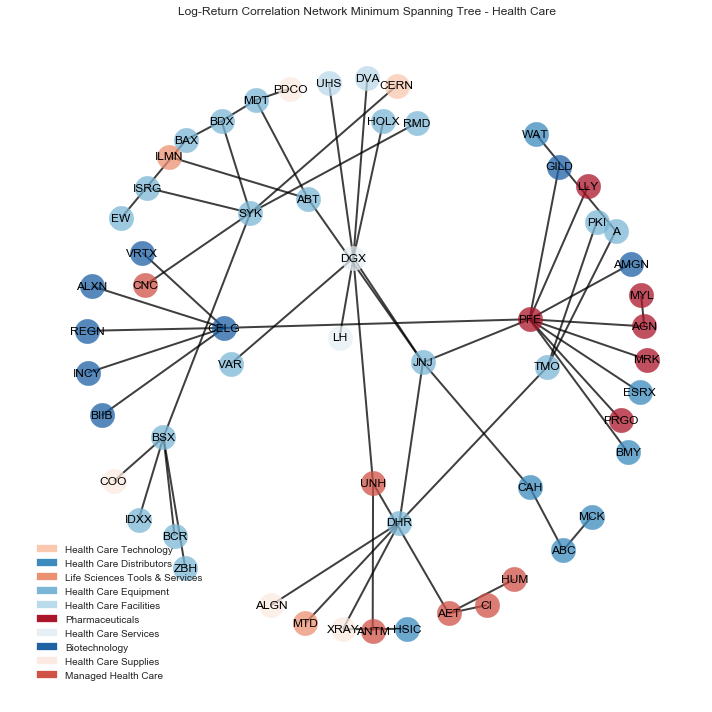

In [299]:
# create position
gicsSector_pos=networkx.spring_layout(gicsSector_tree_graph)
# define title
titleName='Log-Return Correlation Network Minimum Spanning Tree - '+gicsSectorName
# set figure size
plt.figure(figsize=(10,10))
# add title
plt.title(titleName)
# add edges
networkx.draw_networkx_edges(gicsSector_tree_graph,gicsSector_pos,width=2, 
    edge_color='black', alpha=0.75, style="solid")
# add labels
networkx.draw_networkx_labels(gicsSector_tree_graph,gicsSector_pos)
# add nodes
for n in gicsSector_tree_graph.nodes():
    networkx.draw_networkx_nodes(gicsSector_tree_graph, gicsSector_pos, 
    [n], node_size = 600,node_color=gicsSector_tree_graph.node[n]['color'],
    with_labels=True,alpha=0.75)
# remove axis
plt.axis('off')
# add legend
legend_color_patch=list()
# iterate over sub-industry and create patches
for subIndustryName in subIndustry2Color.keys():
    subIndustryColor=subIndustry2Color[subIndustryName]
    color_patch=mpatches.Patch(color=subIndustryColor, 
        label=subIndustryName)
    legend_color_patch.append(color_patch)
# add legend
plt.legend(handles=legend_color_patch)
# set tight layout
plt.tight_layout()
# display the graph
plt.show()

In [300]:
# compute weighted degree
gicsSector_degreeByInstrumentMST=networkx.degree(gicsSector_tree_graph,
    weight='weight')
# convert degree dictionary to dataframe
gicsSector_degreeByInstrumentMstDf=pandas.DataFrame.from_dict(gicsSector_degreeByInstrumentMST,
    orient='index')
# rename column
gicsSector_degreeByInstrumentMstDf.rename(columns={0 : 'degree'},inplace=True)
# join degree and instrument master (by ticker)
degreeByInstrumentMstTable=pandas.merge(gicsSector_degreeByInstrumentMstDf, 
    instrumentMaster, how='inner', left_index=True, right_on='instrumentTicker')
# display result
degreeByInstrumentMstTable.sort_values(ascending=False,
    by=['degree','gicsSubIndustryName'])

,degree,instrumentTicker,instrumentName,gicsSectorName,gicsSubIndustryName
366,10,PFE,Pfizer Inc.,Health Care,Pharmaceuticals
390,7,DGX,Quest Diagnostics,Health Care,Health Care Services
429,6,SYK,Stryker Corp.,Health Care,Health Care Equipment
97,6,CELG,Celgene Corp.,Health Care,Biotechnology
79,5,BSX,Boston Scientific,Health Care,Health Care Equipment
142,5,DHR,Danaher Corp.,Health Care,Health Care Equipment
265,5,JNJ,Johnson & Johnson,Health Care,Health Care Equipment
10,3,AET,Aetna Inc,Health Care,Managed Health Care
461,3,UNH,United Health Group Inc.,Health Care,Managed Health Care
441,3,TMO,Thermo Fisher Scientific,Health Care,Health Care Equipment


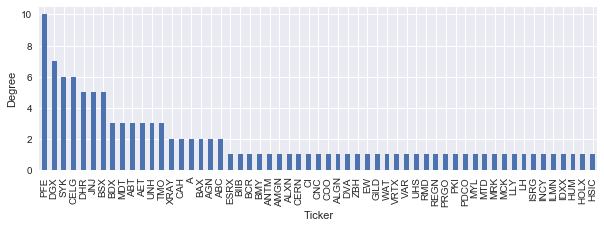

In [301]:
# Plot the sub-industry sector degree by instrument based on 
# the minimal spanning tree (MST)

plt.figure(figsize=(10,3))
gicsSector_degreeByInstrumentMSTDf=pandas.DataFrame(gicsSector_degreeByInstrumentMST,
    index=gicsSector_degreeByInstrumentMST.keys()).iloc[0]
gicsSector_degreeByInstrumentMSTDf.sort_values(ascending=False).plot('bar')
plt.ylabel("Degree")
plt.xlabel("Ticker")